# Amazon Customer Reviews - Exploratory Data Analysis
Springboard Data Science Career Track
Capstone 2
by Chantel Clark

## Data
Amazon has an open dataset of over 130 million customer reviews collected between 1995 and 2015, available as URL’s at https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt. Reviews are grouped by product categories such as apparel, automotive, books, e-books, etc. The columns in the dataset include: ‘marketplace’ (country code), ‘customer_id’, ‘review_id’, ‘product_id’, ‘product_parent’ (random identifier for aggregate reviews for the same product), ‘product_title’, ‘product_category’, ‘star_rating’, ‘helpful_votes’, ‘total_votes’, ‘vine’, ‘verified_purchase’, ‘review_headline’, ‘review_body’, ‘review_date’.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter
from random import sample as rsample
from random import seed
import pickle

In [2]:
# Pandas option - show entire review
pd.set_option('display.max_colwidth', None)

In [3]:
# Import list of suspects, contains customer ID's of those who wrote 30 or more reviews in a day
with open('suspects.pkl', 'rb') as f:
    suspects = pickle.load(f)
# Import list unverified non-suspects    
with open('unverified_non_suspect.pkl', 'rb') as f:
    unverified_non_suspect = pickle.load(f)
# Import list one hit stars
with open('one_hit_stars.pkl', 'rb') as f:
    one_hit_stars = pickle.load(f)

In [4]:
# Import larger data set - Amazon apparel reviews
# Skips 'bad_lines', gets tokenization error without skipping (C error: expected 15 fields, saw 22)
url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz'

url_data = pd.read_table(url, sep='\t', error_bad_lines=False)
url_df = pd.DataFrame(url_data, columns=url_data.keys())
print(url_df.head())

b'Skipping line 49396: expected 15 fields, saw 22\nSkipping line 57008: expected 15 fields, saw 22\n'
b'Skipping line 82075: expected 15 fields, saw 22\nSkipping line 104435: expected 15 fields, saw 22\nSkipping line 109766: expected 15 fields, saw 22\nSkipping line 124024: expected 15 fields, saw 22\nSkipping line 129914: expected 15 fields, saw 22\nSkipping line 130172: expected 15 fields, saw 22\n'
b'Skipping line 161515: expected 15 fields, saw 22\n'
b'Skipping line 230464: expected 15 fields, saw 22\n'
b'Skipping line 292640: expected 15 fields, saw 22\nSkipping line 293681: expected 15 fields, saw 22\nSkipping line 316511: expected 15 fields, saw 22\nSkipping line 317239: expected 15 fields, saw 22\nSkipping line 326099: expected 15 fields, saw 22\nSkipping line 327595: expected 15 fields, saw 22\n'
b'Skipping line 342645: expected 15 fields, saw 22\nSkipping line 347980: expected 15 fields, saw 22\nSkipping line 376258: expected 15 fields, saw 22\nSkipping line 381192: expected 

  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     32158956  R1KKOXHNI8MSXU  B01KL6O72Y        24485154   
1          US      2714559  R26SP2OPDK4HT7  B01ID3ZS5W       363128556   
2          US     12608825   RWQEDYAX373I1  B01I497BGY       811958549   
3          US     25482800  R231YI7R4GPF6J  B01HDXFZK6       692205728   
4          US      9310286  R3KO3W45DD0L1K  B01G6MBEBY       431150422   

                                                                          product_title  \
0  Easy Tool Stainless Steel Fruit Pineapple Corer Slicer Peeler Cut (One size, sliver)   
1    V28 Women Cowl Neck Knit Stretchable Elasticity Long Sleeve Slim Fit Sweater Dress   
2                              James Fiallo Men's 12-Pairs Low Cut Athletic Sport Socks   
3          Belfry Gangster 100% Wool Stain-Resistant Crushable Dress Fedora in 4 Colors   
4          JAEDEN Women's Beaded Spaghetti Straps Sexy Long Formal Prom Evening Dresses   

  produc

In [5]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881874 entries, 0 to 5881873
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   marketplace        object 
 1   customer_id        int64  
 2   review_id          object 
 3   product_id         object 
 4   product_parent     int64  
 5   product_title      object 
 6   product_category   object 
 7   star_rating        float64
 8   helpful_votes      float64
 9   total_votes        float64
 10  vine               object 
 11  verified_purchase  object 
 12  review_headline    object 
 13  review_body        object 
 14  review_date        object 
dtypes: float64(3), int64(2), object(10)
memory usage: 673.1+ MB


There are 5,881,873 reviews in this dataset.

In [6]:
# Convert 'review_date' column to datetime
url_df['review_date'] = pd.to_datetime(url_df['review_date'])

In [7]:
# Date of the oldest review
print('Date of oldest review:', min(url_df['review_date']))
# Date of the newest review
print('Date of newest review:', max(url_df['review_date']))

Date of oldest review: 2000-09-06 00:00:00
Date of newest review: 2015-08-31 00:00:00


In [8]:
# Some of these are not classified correctly...
print(url_df.iloc[0].product_title)
print(url_df.iloc[100].product_title)

Easy Tool Stainless Steel Fruit Pineapple Corer Slicer Peeler Cut (One size, sliver)
Amdirect Portable Parachute Outdoor Travel Camping Beach Canvas Hammock


## Customers

In [9]:
# Create a dictionary of unique customers, with value equal to number of reviews written
customers = dict(url_df['customer_id'].value_counts())

In [10]:
# Convert dictionary to dataframe
customer_df = pd.DataFrame(customers.items(), columns=['customer_ID', 'n_reviews'])
customer_df.head()

,customer_ID,n_reviews
0,50612720,559
1,33883540,351
2,33924372,344
3,37474421,281
4,15006109,262


In [11]:
# Print the total number of unique customers
len(customer_df)

3219083

There are 3,219,083 unique customers

In [12]:
print('The mean number of reviews is %.2f' % np.mean(customer_df.n_reviews))
print('The median number of reviews is', np.median(customer_df.n_reviews))

The mean number of reviews is 1.83
The median number of reviews is 1.0


The average number of reviews that a customer writes is 1.83, while the median number of reviews per customer is 1. Because the average is larger than the median, it is evident that some customers are posting a very large number of reviews which is skewing the dataset to the right (long right tail). The median number of reviews per customer is low, and could be a result of fake accounts where only one review is posted.

Text(0, 0.5, 'Number of customers')

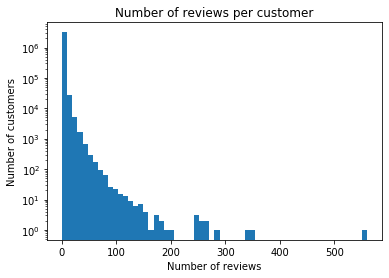

In [13]:
plt.hist(customer_df.n_reviews, bins=60, log=True)
plt.title('Number of reviews per customer')
plt.xlabel('Number of reviews')
plt.ylabel('Number of customers')

In [14]:
# Number of customers that have only posted 1 review 'one hit wonders'
print('Number of one hit wonders', len(customer_df.customer_ID[customer_df.n_reviews == 1]))

# Percentage of customers that post only one review = 68.4%!
n_customers = len(customers)
print('Percent of one hit wonders %.3f' % (len(customer_df.customer_ID[customer_df.n_reviews == 1])/ n_customers *100))

Number of one hit wonders 2201632
Percent of one hit wonders 68.393


In [15]:
n_revs = customer_df.n_reviews
n_revs.describe()

count    3.219083e+06
mean     1.827189e+00
std      2.466301e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.590000e+02
Name: n_reviews, dtype: float64

In [16]:
# Find the skew of the data
n_revs.skew()

19.153069126538394

In [17]:
# Log transform the data
n_revs_log = np.log(customer_df.n_reviews)

# Calculate the interquartile range
iqr = n_revs_log.quantile(0.75) - n_revs_log.quantile(0.25)

# Set whisker length to 3 x IQR. Standard 1.5 x IQR yielded low number of reviews.
whisker_length = 3 * iqr
upper_whisker_loc = n_revs_log.quantile(0.75) + whisker_length
print(upper_whisker_loc)

2.772588722239781


In [18]:
# Transform upper whisker length back to original scale
np.exp(upper_whisker_loc)

15.999999999999998

Customers with more than 5 reviews, considered as outlier when using 1.5 x IQR. Does not seem right because on average, a 'real' (not fake) customer could write around 5 reviews easily. The large amount of customers that write only one review is still skewing the data. Using a whisker length of three times the IQR indicate customers with 16 or more reviews are outliers.


Text(0.5, 0, 'ln(n_reviews)')

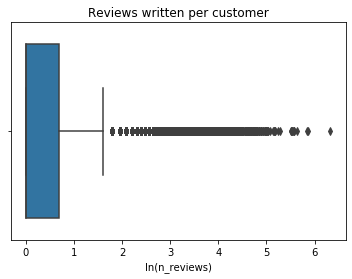

In [19]:
# Create boxplot to identify outliers
sns.boxplot(n_revs_log)
plt.title('Reviews written per customer')
plt.xlabel('ln(n_reviews)')

In [20]:
# Number of 'outliers'
n_outliers = len(n_revs_log[n_revs_log > upper_whisker_loc])
print('outliers:', n_outliers)

outliers: 12400


In [21]:
# Percentage of outliers
n = len(n_revs_log)
n_outliers/n*100

0.3852028667791418

12,400 customers (0.39%) have written more than 16 reviews.

It seems quite plausible that a person might write 17 reviews on clothes over a period of 1 or more years. Other metrics will probably be more informative.

## The most active reviewer

In [22]:
# Check out a sample customer with largest number of reviews - 559 reviews
cid_sample = customer_df.iloc[0].customer_ID
cid_reviews = url_df[url_df['customer_id'] == cid_sample]
cid_reviews.head()


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
5027866,US,50612720,RHNSTL5UZQQTS,B002TPMFL6,15026908,Tunic Top Cotton Kurti-brown Gold Printed Cotton Kurta with Nice Embroidery Small Size,Apparel,4.0,0.0,0.0,N,N,women tunic top,Stunning Cotton Kurti with gorgeous colored print. This ethnic kurti is master piece of Indian Ethnic Art.,2009-10-23
5064403,US,50612720,R2R5WABNC8M64U,B002ON2DB0,744097385,Fashion Blue Skirt Floral Print Fashion Clothes of India Size 36 Inches,Apparel,5.0,0.0,0.0,N,N,Casual Summer Spring Women's Skirt,"This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This printed skirt offers a bohemian style and tie design Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.",2009-09-11
5064413,US,50612720,R2W6U4GDW9Y6GN,B002ON09KC,34396106,Skirts for Women Barmer Print Spring and Summer Fashion Clothes of India Size 36 Inches,Apparel,4.0,0.0,0.0,N,N,casual summer Spring womens Skirt,"This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This crinkle skirt offers a bohemian style and tie design Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.",2009-09-11
5064414,US,50612720,R3NF2BJCZ5BMIX,B002ON07NG,127355835,Designer Skirt Floral Print Spring and Summer Fashion Clothes of India Size 36 Inches,Apparel,5.0,0.0,0.0,N,N,Casual Summer Spring Women's Skirt,"This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This printed skirt offers a bohemian style and tie design Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.",2009-09-11
5064427,US,50612720,RO2B3TWOH87H6,B002OMYEWW,140362456,Skirts for Girl Ethnic Print Spring and Summer Fashion Clothes of India Size 36 Inches,Apparel,5.0,0.0,0.0,N,N,casual summer Spring womens Skirt,"This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This ethnic skirt offers a bohemian style and tie design Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.",2009-09-11


In [23]:
# Are any of these purchases verified?
len(cid_reviews[cid_reviews['verified_purchase'] == 'Y'])

0

None of the purchases from this customer are verified.

In [24]:
# Find the average rating for this reviewer
ave_stars = np.mean(cid_reviews.star_rating)
print(ave_stars)

4.509838998211091


The average star rating for this customer is 4.5.

In [25]:
# Distribution of stars
all_stars = dict(cid_reviews.star_rating.value_counts())
all_stars.update({1.0:0}) # add 0 ratings of 1 star
stars_df = pd.DataFrame(all_stars.items(), columns=['stars', 'n'])
stars_df.head()

,stars,n
0,5.0,324
1,4.0,197
2,3.0,37
3,2.0,1
4,1.0,0


Text(0.5, 0, 'Stars')

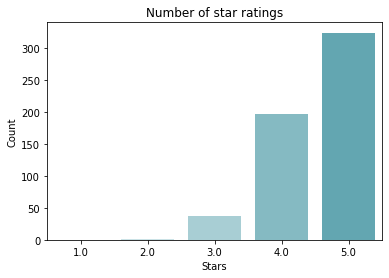

In [26]:
# The distribution of star ratings for this reviewer
pal = sns.light_palette((210, 90, 60), input="husl")
#ax = sns.barplot(x='n', y='stars', data=stars_df, palette=pal, orient='h')
ax = sns.barplot(x='stars', y='n', data=stars_df, palette=pal)
plt.title('Number of star ratings')
plt.ylabel('Count')
plt.xlabel('Stars')

In [27]:
# Where does the review with lowest rating of 2 star come from?
print(cid_reviews[cid_reviews.star_rating == 2.0])

        marketplace  customer_id       review_id  product_id  product_parent  \
5196287          US     50612720  R3W25AC9PE3TZY  B0025TB224       603036081   

                                                            product_title  \
5196287  India Ivory Blue Crepe Print Kurta Shirt Kurti Blouse Yoga Small   

        product_category  star_rating  helpful_votes  total_votes vine  \
5196287          Apparel          2.0            0.0          2.0    N   

        verified_purchase      review_headline  \
5196287                 N  printed crepe Kurti   

                                                                                                                                                                                                                                                                                   review_body  \
5196287  Bollywood Style Designer Indian Kurti - Unique Indian Kurtis for Women -Summer Dress lucknowi-chikan-- It's the latest in Indian fashio

This text from this review is an advertisement and does not match the low 2 star rating. 

In [28]:
# Check out the dates that reviews were posted
dates = dict(cid_reviews['review_date'].value_counts())
dates_df = pd.DataFrame(dates.items(), columns=['review_date', 'n'])
dates_df

,review_date,n
0,2009-07-23,147
1,2009-07-21,132
2,2009-07-25,65
3,2009-07-19,47
4,2009-07-30,29
5,2009-08-10,28
6,2009-08-11,28
7,2009-09-11,28
8,2009-08-31,28
9,2009-08-06,10


In [29]:
def get_freq(cid):
    """ Returns a dictionary of unique dates and total number of reviews """
    cid_reviews = url_df[url_df['customer_id'] == cid]
    dates = dict(cid_reviews['review_date'].value_counts())
    return dates

Text(0, 0.5, 'Reviews')

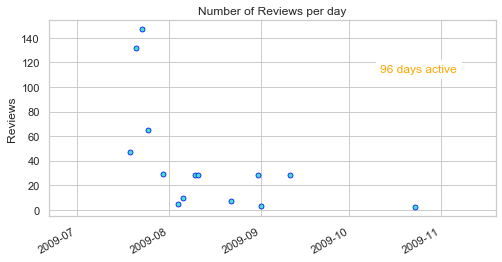

In [30]:
# Scatter plot of the number of reviews over time
suspect0 = get_freq(cid_sample) # customer with most 
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(8,4))
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.MonthLocator()) # for suspect0 formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m")) # for suspect0 formatting
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m")) # for suspect0 formatting
x = suspect0.keys()
y = suspect0.values()
plt.scatter(x, y, s=25, c='turquoise', edgecolor='blue', linewidths=0.75)
# Get days active
days = str(max(suspect0.keys()) - min(suspect0.keys())).split(' ')[0] + ' days active'
plt.text(0.7,0.7, s=days, c='orange', fontsize=12, transform=fig.transFigure,
         bbox=dict(facecolor='white', alpha=1))
plt.title('Number of Reviews per day')
plt.ylabel('Reviews')


In [31]:
print('Start date:', min(dates_df.review_date))
print('End date:', max(dates_df.review_date))
max(dates_df.review_date) - min(dates_df.review_date)

Start date: 2009-07-19 00:00:00
End date: 2009-10-23 00:00:00


Timedelta('96 days 00:00:00')

In July 21 and 23 of year 2009, there were over 100 reviews posted. Number of reviews decreases drastically throught October 2009. One way to flag suspicious review activity is to identify a maximum limit of reviews written per day for each reviewer. In this case, it would be reasonable to say that writing over 20 reviews is suspicious. We could take into consideration how long the customer has been an active reviewer.

In [32]:
# View the last two reviews from customer
print(cid_reviews.loc[cid_reviews.review_date == pd.to_datetime('2009-10-23'), ['star_rating', 'review_body']])

         star_rating  \
5027866          4.0   
5114509          4.0   

                                                                                                                                                                                                                                                                                         review_body  
5027866                                                                                                                                                                                   Stunning Cotton Kurti with gorgeous colored print. This ethnic kurti is master piece of Indian Ethnic Art.  
5114509  Our classic cotton boho tie skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This crinkle skirt offers a bohemian style, tie design, and elastic waistline. Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.  


In [33]:
# View other products that are reviewed by this customer
dict(cid_reviews['product_title'].value_counts()[0:10])

{'Womens Top Crepe Full Sleeve Kurti/ Blouse/boho/yoga Top L': 10,
 'White Tunic Yoga Cotton Kurti Clothing of India Casual Summer Dresses Chikan Embroidery Size M': 10,
 'Womens Kurti Crepe Full Sleeve Top Blouse/boho/yoga Top L': 6,
 'Cotton Floral Print Tunics Womens Shirts Tops Indian Kurtis Size M': 5,
 'White Tunic Yoga Cotton Kurti Clothing of India Casual Summer Dresses Chikan Embroidery Size L': 5,
 'Designer White Cotton Embrdy Kurta Shirt Kurti Blouse L': 5,
 'Cotton Long Skirt Summer Spring Fashion Casual Boho Bellydance Indian Clothing': 5,
 'Designer Ivory Cotton Chikan Embroidery Summer Kurta Tunic Top Yoga Size L': 4,
 'Black Tunic Yoga Cotton Kurti Clothing of India Casual Summer Dresses Designer Embroidery Size M': 4,
 'White Cotton Tunic Kurtis Womens Shirts Tops Spring Summer Clothes Hand Embroidery Size M': 4}

This customer reviewed many of the same types of items, and clothing items of various sizes. 

In [34]:
cid_reviews.iloc[0:10].review_body

5027866                                                                                                                                                                  Stunning Cotton Kurti with gorgeous colored print. This ethnic kurti is master piece of Indian Ethnic Art.
5064403    This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This printed skirt offers a bohemian style and tie design Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.
5064413    This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This crinkle skirt offers a bohemian style and tie design Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.
5064414    This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This printed skirt offers a bohemian 

In [35]:
cid_reviews.iloc[500:511].review_body

5196271                                 This pretty floral print defines your diva status. Allover print tunic with sequence embroidery round neckline, 3/4th sleeves, and designer print in the front and the same design runs straight in both side of the sleeves to give it a finished look.
5196272                                                                                                                                  Stunning Cotton Kurti with gorgeous embroidery. This ethnic embroidery kurti is master piece of Indian Ethnic Art. Must have collection for party wear.
5196273                                             This pretty floral print defines your diva status. Allover print tunic with a solid round neckline, 3/4th sleeves, and designer print in the front and the same design runs straight in both side of the sleeves to give it a finished look.
5196274    Bollywood Style Designer Indian Kurti - Unique Indian Kurtis for Women -Summer Dress lucknowi-chikan-- It's the latest in 

These definitely look like fake/unreliable reviews because of the repeated text for multiple reviews. Extremely large number of similar reviews can be an indicator of unreliable reviews.

## Get other suspicious customers

In [36]:
def plot_dict(d):
    """ Creates scatter plot of reviews per day"""
    sns.set(style='whitegrid')
    fig, ax = plt.subplots(figsize=(8,4))
    fig.autofmt_xdate()
    x = d.keys()
    y = d.values()
    plt.scatter(x, y, s=25, c='turquoise', edgecolor='blue', linewidths=0.75)
    # Get days active
    days = str(max(d.keys()) - min(d.keys())).split(' ')[0] + ' days active'
    plt.text(0.7,0.7, s=days, c='orange', fontsize=12, transform=fig.transFigure,
            bbox=dict(facecolor='white', alpha=1))
    plt.title('Number of Reviews per day')
    plt.ylabel('Reviews')

In [37]:
""" 
# If you don't have the pickled list of suspects 'suspects.pkl', run this cell

# Trim customer_df to customers with >= 30 reviews
customer_df3 = customer_df[customer_df.n_reviews >= 30]
customer_df3.tail()

# Find which customers posted 30 ore more reviews in a day
suspects = [] # initialize list
for cid in customer_df3.customer_ID:
    dates = get_freq(cid)
    # Find number of days where 30 or more reviews were posted
    n = len([(k,v) for k,v in dates.items() if v >= 30])
    if n > 0:
        suspects.append(cid)
"""

" \n# If you don't have the pickled list of suspects 'suspects.pkl', run this cell\n\n# Trim customer_df to customers with >= 30 reviews\ncustomer_df3 = customer_df[customer_df.n_reviews >= 30]\ncustomer_df3.tail()\n\n# Find which customers posted 30 ore more reviews in a day\nsuspects = [] # initialize list\nfor cid in customer_df3.customer_ID:\n    dates = get_freq(cid)\n    # Find number of days where 30 or more reviews were posted\n    n = len([(k,v) for k,v in dates.items() if v >= 30])\n    if n > 0:\n        suspects.append(cid)\n"

In [38]:
# Total number of suspects
print('Total number of suspects:', len(suspects))
suspects[:5]

Total number of suspects: 268


[50612720, 33883540, 33924372, 32254988, 12919673]

In [39]:
"""
# Pickle the suspects list

import pickle

with open('suspects.pkl', 'wb') as f:
    pickle.dump(suspects, f)
    """

"\n# Pickle the suspects list\n\nimport pickle\n\nwith open('suspects.pkl', 'wb') as f:\n    pickle.dump(suspects, f)\n    "

In [40]:
suspect1 = get_freq(suspects[1])
suspect1

{Timestamp('2008-06-16 00:00:00'): 214,
 Timestamp('2008-06-15 00:00:00'): 83,
 Timestamp('2008-12-04 00:00:00'): 23,
 Timestamp('2008-10-24 00:00:00'): 13,
 Timestamp('2008-10-23 00:00:00'): 11,
 Timestamp('2010-08-10 00:00:00'): 3,
 Timestamp('2010-08-08 00:00:00'): 1,
 Timestamp('2009-02-19 00:00:00'): 1,
 Timestamp('2010-08-06 00:00:00'): 1,
 Timestamp('2010-08-09 00:00:00'): 1}

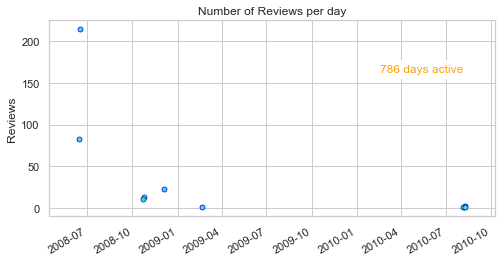

In [41]:
plot_dict(suspect1)

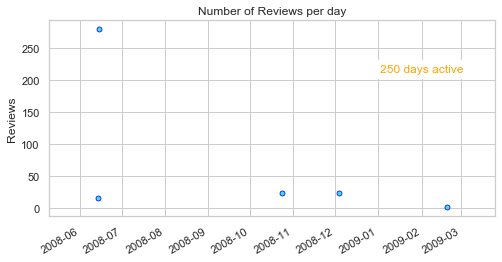

In [42]:
suspect2 = get_freq(suspects[2])
plot_dict(suspect2)

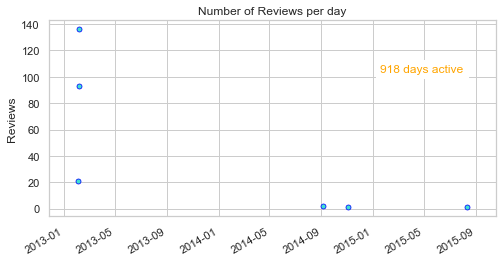

In [43]:
suspect3 = get_freq(suspects[3])
plot_dict(suspect3)

## Unverified Purchases

In [44]:
# Out of all reviews, find the percentage of unverified reviews
print('Percentage of unverified purchases = %.1f' % (len(url_df[url_df.verified_purchase == 'N'])/len(url_df) * 100))

Percentage of unverified purchases = 10.1


In [45]:
def get_unverified(cid):
    """ Returns customer ID if there is at least one unverified purchase"""
    temp = url_df[url_df['customer_id'] == cid]
    no = temp[temp.verified_purchase == 'N']
    if len(no) > 0:
        return cid

In [46]:
# Create list of customer IDs for suspects with unverified purchases
unverified_suspect = [get_unverified(cid) for cid in suspects]
# remove Nones from list
unverified_suspect = [v for v in unverified_suspect if v]
unverified_suspect_n = len(unverified_suspect)
print(unverified_suspect_n)

147


In [47]:
# Proportion of suspects with at least 1 unverified purchase
print(unverified_suspect_n/len(suspects))

0.5485074626865671


In [48]:
all_cids = url_df.customer_id.unique()
len(all_cids)

3219083

In [49]:
# All customer_IDs that are NOT in the suspect list
non_suspects = [x for x in all_cids if x not in suspects]

In [50]:
len(non_suspects) + len(suspects)

3219083

In [51]:
"""
%%time
# Create list of customer IDs for non-suspects with unverified purchases
unverified_non_suspect = [get_unverified(cid) for cid in non_suspects]
# remove Nones from list
unverified_non_suspect = [v for v in unverified_non_suspect if v]
"""

unverified_non_suspect_n = len(unverified_non_suspect)

In [52]:
"""
# Pickle the unverified_non_suspect list

with open('unverified_non_suspect.pkl', 'wb') as f:
    pickle.dump(unverified_non_suspect, f)
"""

"\n# Pickle the unverified_non_suspect list\n\nwith open('unverified_non_suspect.pkl', 'wb') as f:\n    pickle.dump(unverified_non_suspect, f)\n"

In [53]:
# Proportion of non-suspects with at least 1 unverified purchase
print(unverified_non_suspect_n/len(non_suspects))

0.13764506503169643


The proportion of suspects with unverified purchases (0.549) is much greater than the proportion of non-suspect customers with unverified purchases (0.138).

## Vine Customers

In [54]:
# Num vine reviews
print('Number of vine reviews:', len(url_df[url_df.vine=='Y']))
# Num unique vine reviewers 
vine_reviewers = url_df[url_df.vine=='Y'].customer_id.unique()
print('Number of unique vine customers:', len(vine_reviewers))

Number of vine reviews: 2329
Number of unique vine customers: 1187


In [55]:
# Find the total number of reviews for each vine reviewer
total_vine_revs = []

for reviewer in vine_reviewers:
    reviews = url_df[url_df['customer_id'] == reviewer]
    total_vine_revs.append(len(reviews))
    if len(reviews) == 115:
        print('Customer ID with 115 reviews is:', reviewer)

print('Reviews per vine customer: min = {}; max = {}'.format(min(total_vine_revs), max(total_vine_revs)))

Customer ID with 115 reviews is: 27598356
Reviews per vine customer: min = 1; max = 115


In [56]:
# Find the total number of reviews for each suspicious reviewer
total_susp_revs = []

for reviewer in suspects:
    reviews = url_df[url_df['customer_id'] == reviewer]
    total_susp_revs.append(len(reviews))

print('Reviews per suspect: min = {}; max = {}'.format(min(total_susp_revs), max(total_susp_revs)))  

Reviews per suspect: min = 30; max = 559


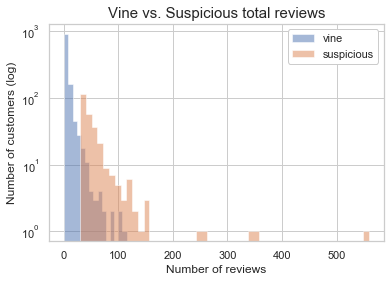

In [57]:
plt.hist(total_vine_revs, histtype='stepfilled', bins=15, label='vine', alpha=0.5)
plt.hist(total_susp_revs, histtype='stepfilled', bins=50, label='suspicious', alpha=0.5)

plt.title('Vine vs. Suspicious total reviews', fontsize=15)
plt.ylabel('Number of customers (log)')
plt.xlabel('Number of reviews')
plt.yscale('log')
plt.legend(frameon=True, facecolor='white', framealpha=1)

In [58]:
def max_dict_value(d):
    max_val = 0
    for k,v in d.items():
        if v > max_val:
            max_val = v
    return max_val

In [59]:
# Get the maximum number of reviews written per day for vine reviewers
vine_revs_pd = []

for reviewer in vine_reviewers:
    temp = get_freq(reviewer)
    maxv = max_dict_value(temp)
    vine_revs_pd.append(maxv)

In [60]:
# Get the maximum number of reviews written per day for suspicious reviewers
susp_revs_pd = []

for reviewer in suspects:
    temp = get_freq(reviewer)
    maxv = max_dict_value(temp)
    susp_revs_pd.append(maxv)

In [61]:
print('Maximum number of review within a day: Vine {}; Suspect {}'.format(max(vine_revs_pd), max(susp_revs_pd)))

Maximum number of review within a day: Vine 32; Suspect 280


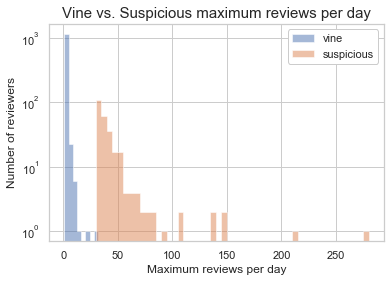

In [62]:
# Histogram, reviews per day
plt.hist(vine_revs_pd, histtype='stepfilled', bins=8, alpha=0.50, label='vine')
plt.hist(susp_revs_pd, histtype='stepfilled', bins=50, alpha=0.50, label='suspicious')
plt.yscale('log')
plt.title('Vine vs. Suspicious maximum reviews per day', fontsize=15)
plt.xlabel('Maximum reviews per day')
plt.ylabel('Number of reviewers')
plt.legend(frameon=True, facecolor='white', framealpha=1)

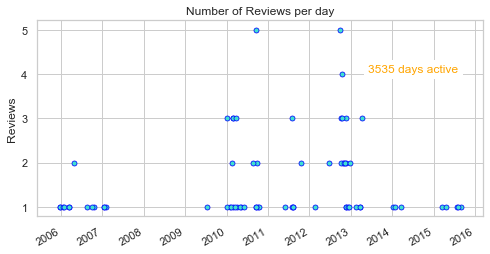

In [63]:
# Vine reviewer with the most reviews
plot_dict(get_freq(27598356))

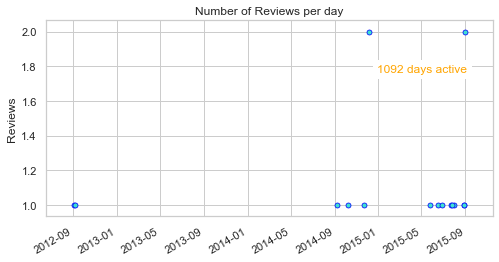

In [64]:
# View frequency of posts for a vine reviewer
plot_dict(get_freq(34571698))

## One-review customers

Customers who wrote exactly one review in this apparel dataset.

In [65]:
"""
%%time
# Star ratings of 1-review customers (2.2 million)
one_hit_cust = customer_df.customer_ID[customer_df.n_reviews == 1]
one_hit_stars = [url_df[url_df['customer_id']==cid].star_rating.iloc[0] for cid in one_hit_cust]
"""

"\n%%time\n# Star ratings of 1-review customers (2.2 million)\none_hit_cust = customer_df.customer_ID[customer_df.n_reviews == 1]\none_hit_stars = [url_df[url_df['customer_id']==cid].star_rating.iloc[0] for cid in one_hit_cust]\n"

**~6 hours to run the code above**

In [66]:
"""
# Pickle the one_hit_stars list
with open('one_hit_stars.pkl', 'wb') as f:
    pickle.dump(one_hit_stars, f)
"""

"\n# Pickle the one_hit_stars list\nwith open('one_hit_stars.pkl', 'wb') as f:\n    pickle.dump(one_hit_stars, f)\n"

In [67]:
# The number of customers who wrote exactly 1 review
print(len(one_hit_stars))

2201632


In [68]:
# Star distribution of all reviews from customers who wrote exactly 1 review
Counter(one_hit_stars)

Counter({3.0: 223733, 4.0: 416831, 5.0: 1190173, 2.0: 150804, 1.0: 220091})

In [69]:
# Average stars from those who wrote one review
#total/len(one_hit_stars)
print(np.mean(one_hit_stars))

4.0020707366172


In [70]:
# Proportion of 5-star reviews
print(1190173/2201632)
# Proportion of 4-star reviews
print(416831/2201632)

0.5405867102222351
0.1893281892705048


Text(0.5, 0, 'Star rating')

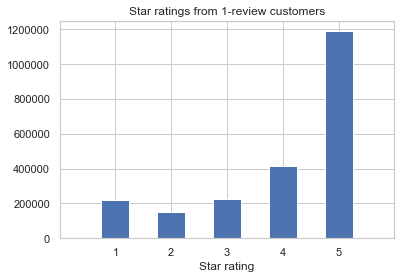

In [71]:
plt.hist(one_hit_stars, bins=np.arange(1,7)-.5, rwidth=0.5)
plt.title('Star ratings from 1-review customers')
plt.xticks(range(1,6))
plt.xlim([0,6])
plt.xlabel('Star rating')

In [72]:
# print out the reviews from a sample of 50 customers who have only posted one review
seed(100)
for cid in rsample(set(customer_df.customer_ID[customer_df.n_reviews == 1]), 50):
    temp = url_df[url_df.customer_id == cid]
    print(temp)
    print()

        marketplace  customer_id       review_id  product_id  product_parent  \
4357066          US     13732236  R127Y052U1XS4W  B0058F1ULU         2992394   

                                      product_title product_category  \
4357066  SNUG Bralette Bra (AP12811) one size/Black          Apparel   

         star_rating  helpful_votes  total_votes vine verified_purchase  \
4357066          5.0            0.0          0.0    N                 Y   

        review_headline  \
4357066      Love this!   

                                                                                          review_body  \
4357066  Great product, fits right on the dot and looks very nice when you have too low cut of a top.   

        review_date  
4357066  2015-05-02  

        marketplace  customer_id       review_id  product_id  product_parent  \
5708633          US     45552560  R1J9M196TSB8FM  B000GISWJM       647636940   

                                                                      p

1173021  2014-07-24  

        marketplace  customer_id       review_id  product_id  product_parent  \
2571971          US      9986535  R2AXDRSO5MDHGQ  B00D85Z78Y       637662178   

                                                  product_title  \
2571971  Thorlo Women's Distance Walker Thick Padded Ankle Sock   

        product_category  star_rating  helpful_votes  total_votes vine  \
2571971          Apparel          5.0            0.0          0.0    N   

        verified_purchase          review_headline  \
2571971                 Y  Great American Product!   

                         review_body review_date  
2571971  Best socks made in the USA!  2015-06-24  

        marketplace  customer_id       review_id  product_id  product_parent  \
1997472          US      9796708  R1345108JWHY04  B00G5NLMFS       772634991   

                          product_title product_category  star_rating  \
1997472  Salomon Impulse Ski Pants Mens          Apparel          3.0   

         hel

2947789  2015-04-06  

        marketplace  customer_id      review_id  product_id  product_parent  \
3877695          US      6325215  RZBVNLAF56MVH  B007J6W24K       555611828   

                                                        product_title  \
3877695  Baby Boy and Toddler Boy Tuxedo and Suit and Tie (0-3 mo-4T)   

        product_category  star_rating  helpful_votes  total_votes vine  \
3877695          Apparel          5.0            0.0          0.0    N   

        verified_purchase   review_headline  \
3877695                 Y  Good experience.   

                                                       review_body review_date  
3877695  This is so cute...delivered to me fast.  Good experience.  2014-12-09  

        marketplace  customer_id      review_id  product_id  product_parent  \
3313156          US     15460537  RST06VCSO4ULF  B009S3HYQ8       879333874   

                                                              product_title  \
3313156  Ever Pretty NWT O

        marketplace  customer_id       review_id  product_id  product_parent  \
1280485          US     22255314  R129IDT0TE0VAP  B00K16GBCE       161708565   

                                                         product_title  \
1280485  Wantdo Girl's One Piece Swimsuit Rainbow Wave Tiered Swimwear   

        product_category  star_rating  helpful_votes  total_votes vine  \
1280485          Apparel          5.0            0.0          0.0    N   

        verified_purchase review_headline                    review_body  \
1280485                 Y      Five Stars  Awesome. Adorable. Well made!   

        review_date  
1280485  2015-05-13  

        marketplace  customer_id       review_id  product_id  product_parent  \
5669039          US     47653435  R306KUZNMU4XED  B000JLJZO2       765413754   

                                           product_title product_category  \
5669039  Peanuts Charlie Brown Zig Zag Stripe Shirt (XL)          Apparel   

         star_rating  helpf

        marketplace  customer_id       review_id  product_id  product_parent  \
4996049          US     52247414  R3LCSXHO9V0F6J  B002ZLOIAA       773181687   

                                                           product_title  \
4996049  Haggar Men's eCLo Stria Expandable-Waist Plain-Front Dress Pant   

        product_category  star_rating  helpful_votes  total_votes vine  \
4996049          Apparel          4.0            0.0          0.0    N   

        verified_purchase      review_headline  \
4996049                 Y  NIce looking Slacks   

                                                                                                                       review_body  \
4996049  These dress pants look very good. The pictures on the web page are very accurate and the slack fit exactly as I expected.   

        review_date  
4996049  2014-06-16  

        marketplace  customer_id       review_id  product_id  product_parent  \
1677266          US     12422457  R28CR2GS

In [73]:
# print out the reviews from customers who are not verified, have 0 helpful votes, and have only posted one review
seed(50)
for cid in rsample(set(customer_df.customer_ID[customer_df.n_reviews == 1]), 50):
    condition = (url_df.customer_id == cid) & (url_df['verified_purchase'] == 'N') & (url_df['helpful_votes'] == 0)
    if len(url_df[condition]) != 0:
        temp = url_df[condition]
        #print(temp.star_rating, temp.review_headline, temp.review_body)
        print(temp)
        print()

        marketplace  customer_id       review_id  product_id  product_parent  \
3651631          US     27952423  R1SUD5HLQAGVBN  B008APCZJQ       573266860   

                                          product_title product_category  \
3651631  Women's 100% linen pants with drawstring waist          Apparel   

         star_rating  helpful_votes  total_votes vine verified_purchase  \
3651631          5.0            0.0          0.0    N                 N   

        review_headline  \
3651631       Love them   

                                                                                                                                            review_body  \
3651631  Fits true to size BUT don't be alarmed when you put them on the hips are a little tight.  Trust me that they will loosen to a comfortable fit.   

        review_date  
3651631  2012-08-11  

        marketplace  customer_id       review_id  product_id  product_parent  \
1642374          US     51005395  R15B1UPFBL

Nothing especially suspicious even from the reviews with 0 helpful votes, and have unverified purchase.